In [1]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import numpy as np
import os
import nibabel as nib

# 4D-UNet model
from models import UNet4D 

# Helper functions
from train_utils import predictions, CreateDataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

torch.set_default_dtype(torch.float32) 

Device: cuda


In [3]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed(42)

In [4]:
X_test_path = '../preprocessed_4d/ls_test'
y_test_path = '../preprocessed_4d/epi_test'

In [5]:
X_test_files = [f for f in os.listdir(X_test_path) if f.endswith('.pt')]
X_test = [torch.load(os.path.join(X_test_path, f)) for f in X_test_files]

C:\Users\Caroline\AppData\Local\Temp\ipykernel_3536\101806639.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_test = [torch.load(os.path.join(X_test_path, f)) for f in

In [6]:
y_test_files = [f for f in os.listdir(y_test_path) if f.endswith('.pt')]
y_test = [torch.load(os.path.join(y_test_path, f)) for f in y_test_files]

C:\Users\Caroline\AppData\Local\Temp\ipykernel_3536\4135945730.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  y_test = [torch.load(os.path.join(y_test_path, f)) for f i

### Loading the best model

In order to determine the generalizability, the best performing model is loaded and evaluated on the test data, which is previosly unseen for the model.

In [ ]:
test_dataset = CreateDataset(X_test, y_test)

best_MSE_model = UNet4D()

checkpoint_MSE = torch.load('./4D_model_weights/MSE_lr5e-5/weights_model_lr5e-05_epoch30.pth', map_location=device)
best_MSE_model.load_state_dict(checkpoint_MSE['model_state_dict'])

best_MSE_model.eval()

best_MSE_model.to(device=device)
set_seed(42)
batch_size = 1
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(42))
preds, true = predictions(best_MSE_model, test_loader)

preds_cpu = preds[0].cpu()
true_cpu = true[0].cpu()
preds0= preds_cpu.squeeze(0,1)
true0= true_cpu.squeeze(0,1)

C:\Users\Caroline\AppData\Local\Temp\ipykernel_3536\831520233.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_MSE = torch.load('./4D_model_weights/MSE_lr5e-5/

### tSNR calculation

A common evaluation metric is signal-to-noise ratio (SNR), which measures the amount of background noise in comparison to the signal intensity. As the data is 4D, temporal SNR (tSNR) is calculated. SNR is calculated by taking the mean value of a region of interest (ROI) in the brain, dividing it on the standatd deviation of an ROI in the background.

In [4]:
def calc_SNR(image, image_type):
    """ 
    Calculation tSNR for three types of images. 

    Parameters:
    - image: 4D volume to calculate tSNR on.
    - image_type: Type of image to calculate tSNR on. The ROI will be defined differently depending on the image and position of the brain.

    Returns:
    - snr: The computed tSNR.
    """
    
    if image_type == 'EPI':
        ROI_image = image[:,25:30,25:30,25:30]
        ROI_noise =  image[:,9:14,15:20,30:35] 
        
    elif image_type == 'Recon':
        ROI_image = image[:,25:30,25:30,25:30]
        ROI_noise = image[:,5:10,15:20,30:35] 

    elif image_type == 'LS':
        ROI_image =  image[:,25:30,25:30,35:40]
        ROI_noise = image[:,3:8,11:16,30:35]
    
    mean_signal = torch.mean(ROI_image)
    std_signal = torch.std(ROI_noise)

    print(mean_signal, std_signal)

    snr = mean_signal/(std_signal+1e-6) # Adding a small number to avoid division by zero

    return snr

### Determine ROI positions

As SNR is determined based on mean intensity of a ROI in the brain and the standard deviation of a ROI outside the brain, the positins were determined based on visualization of the selected areas. The plots below show how these regions were determined.

The image used for SNR calculation is plotted, with the ROI highlighted in red.

#### ROI position of EPI

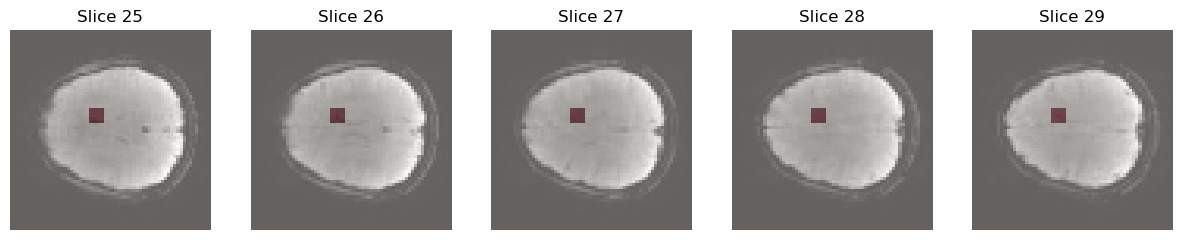

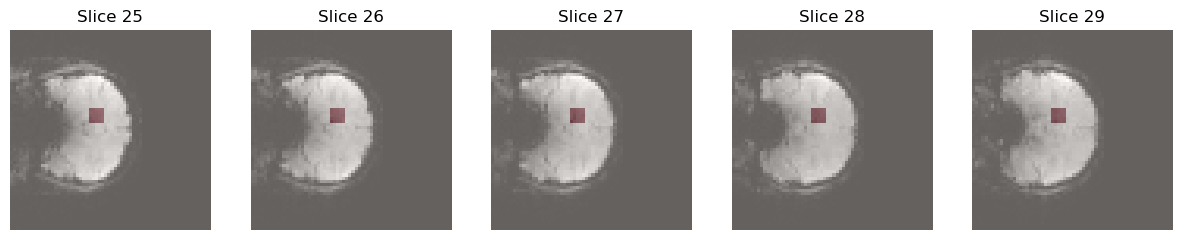

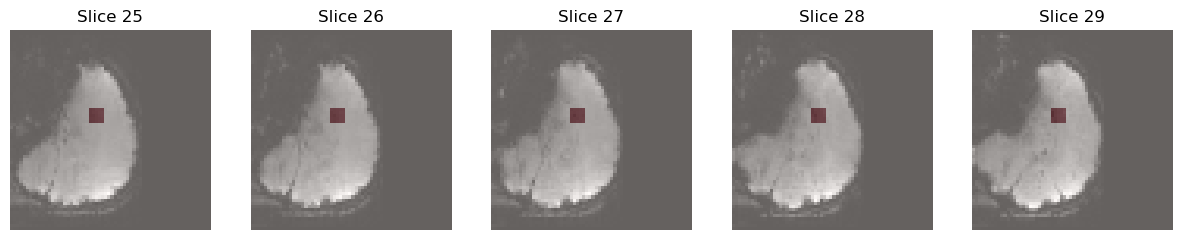

In [121]:
mask = np.zeros((64,64,64), dtype=bool)
mask[25:30,25:30,25:30] = True

fig, ax = plt.subplots(1,5, figsize=(15,5))
slices_to_show =[i for i in range(25,30)]

for i, z in enumerate(slices_to_show):
    ax[i].imshow(true0[12, :, :, z], cmap='gray')
    ax[i].imshow(mask[:, :, z], cmap='Reds', alpha=0.4)
    ax[i].set_title(f'Slice {z}')
    ax[i].axis('off')

plt.show()

fig, ax = plt.subplots(1,5, figsize=(15,5))
slices_to_show =  [i for i in range(25,30)]

for i, z in enumerate(slices_to_show):
    ax[i].imshow(true0[12, :, z, :], cmap='gray')
    ax[i].imshow(mask[:, z, :], cmap='Reds', alpha=0.4)
    ax[i].set_title(f'Slice {z}')
    ax[i].axis('off')

plt.show()

fig, ax = plt.subplots(1,5, figsize=(15,5))
slices_to_show =[i for i in range(25,30)]

for i, z in enumerate(slices_to_show):
    ax[i].imshow(true0[12, z, :, :], cmap='gray')
    ax[i].imshow(mask[z, :, :], cmap='Reds', alpha=0.4)
    ax[i].set_title(f'Slice {z}')
    ax[i].axis('off')

plt.show()

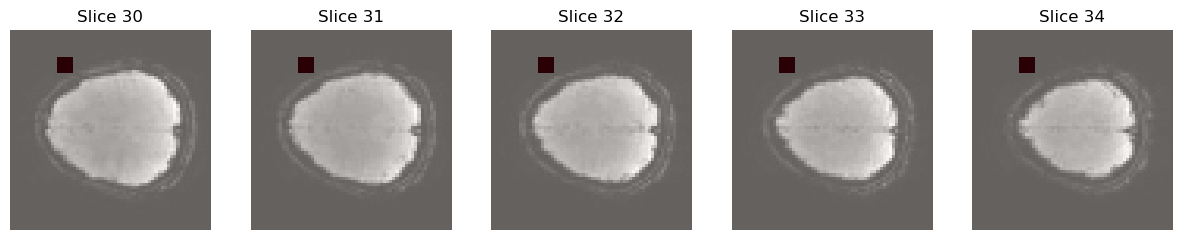

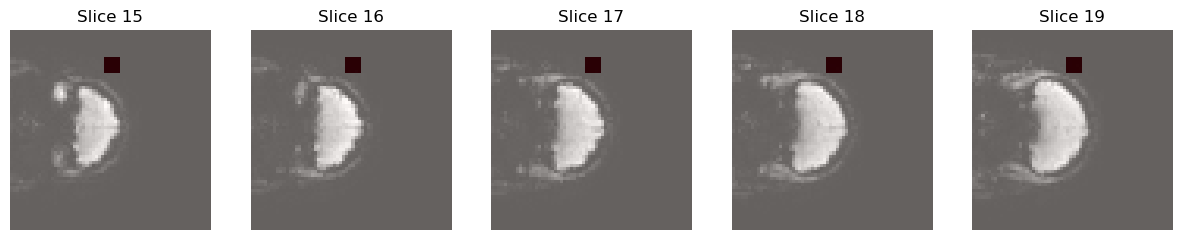

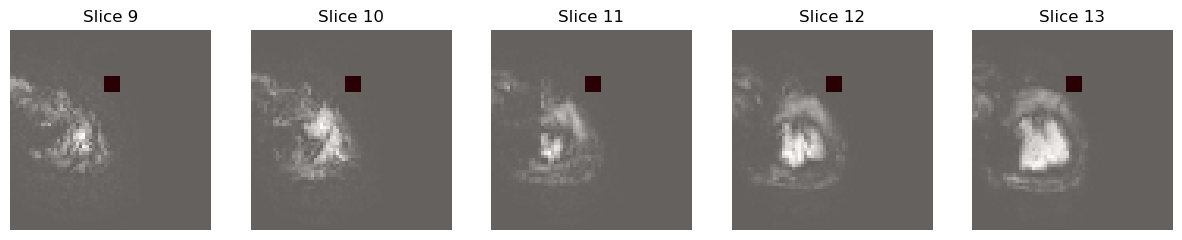

In [ ]:
mask_true_noise = np.zeros((64,64,64), dtype=bool)
mask_true_noise[9:14,15:20,30:35] = True

fig, ax = plt.subplots(1,5, figsize=(15,5))
slices_to_show = [i for i in range(30,35)]

for i, z in enumerate(slices_to_show):
    ax[i].imshow(true0[12, :, :, z], cmap='gray')
    ax[i].imshow(mask_true_noise[:, :, z], cmap='Reds', alpha=0.4)
    ax[i].set_title(f'Slice {z}')
    ax[i].axis('off')

plt.show()

fig, ax = plt.subplots(1,5, figsize=(15,5))
slices_to_show = [i for i in range(15,20)]


for i, z in enumerate(slices_to_show):
    ax[i].imshow(true0[12, :, z, :], cmap='gray')
    ax[i].imshow(mask_true_noise[:, z, :], cmap='Reds', alpha=0.4)
    ax[i].set_title(f'Slice {z}')
    ax[i].axis('off')

plt.show()

fig, ax = plt.subplots(1,5, figsize=(15,5))
slices_to_show = [i for i in range(9,14)]

for i, z in enumerate(slices_to_show):
    ax[i].imshow(true0[12, z, :, :], cmap='gray')
    ax[i].imshow(mask_true_noise[z, :, :], cmap='Reds', alpha=0.4)
    ax[i].set_title(f'Slice {z}')
    ax[i].axis('off')

plt.show()

### tSNR of EPI

In [145]:
calc_SNR(image=true0, image_type='EPI')

tensor(0.3794) tensor(0.0016)


tensor(229.9294)

### ROI position of predictions

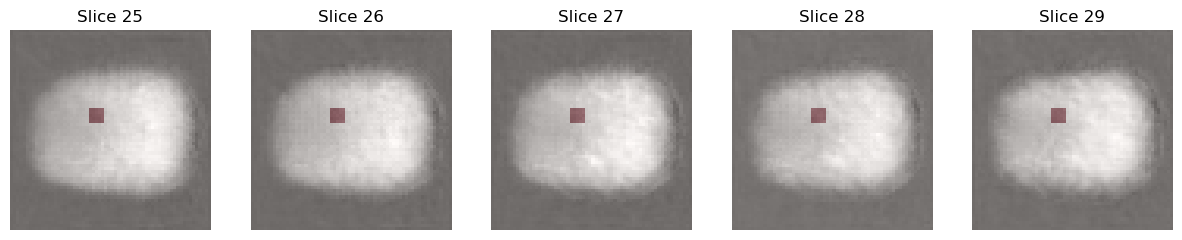

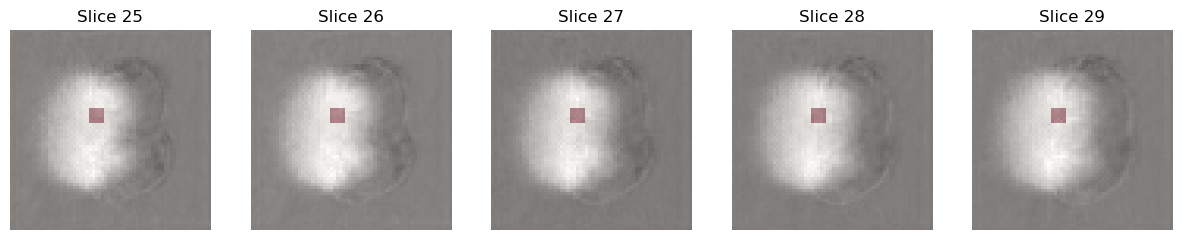

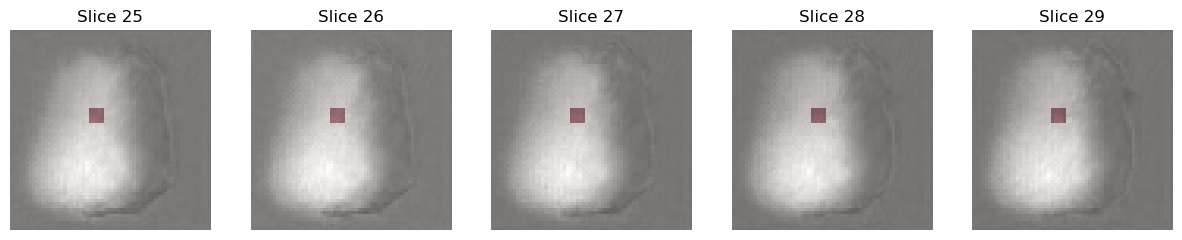

In [37]:
mask_preds = np.zeros((64,64,64), dtype=bool)
mask_preds[25:30,25:30,25:30] = True

fig, ax = plt.subplots(1,5, figsize=(15,5))
slices_to_show = [i for i in range(25,30)]

for i, z in enumerate(slices_to_show):
    ax[i].imshow(preds0[12, :, :, z], cmap='gray')
    ax[i].imshow(mask_preds[:, :, z], cmap='Reds', alpha=0.4)
    ax[i].set_title(f'Slice {z}')
    ax[i].axis('off')

plt.show()

fig, ax = plt.subplots(1,5, figsize=(15,5))
slices_to_show =  [i for i in range(25,30)]

for i, z in enumerate(slices_to_show):
    ax[i].imshow(preds0[12, :, z, :], cmap='gray')
    ax[i].imshow(mask_preds[:, z, :], cmap='Reds', alpha=0.4)
    ax[i].set_title(f'Slice {z}')
    ax[i].axis('off')

plt.show()

fig, ax = plt.subplots(1,5, figsize=(15,5))
slices_to_show = [i for i in range(25,30)]

for i, z in enumerate(slices_to_show):
    ax[i].imshow(preds0[12, z, :, :], cmap='gray')
    ax[i].imshow(mask_preds[z, :, :], cmap='Reds', alpha=0.4)
    ax[i].set_title(f'Slice {z}')
    ax[i].axis('off')

plt.show()

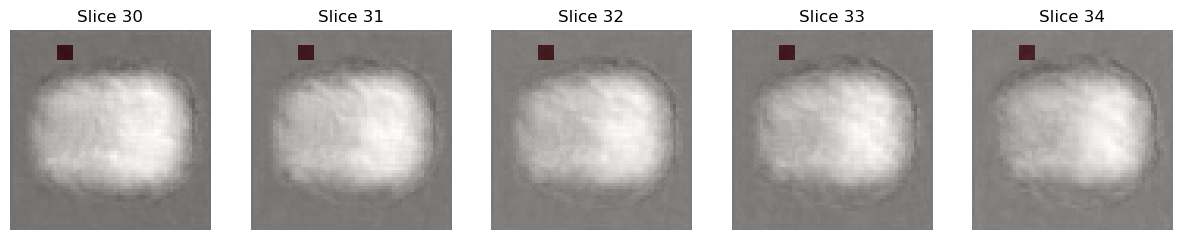

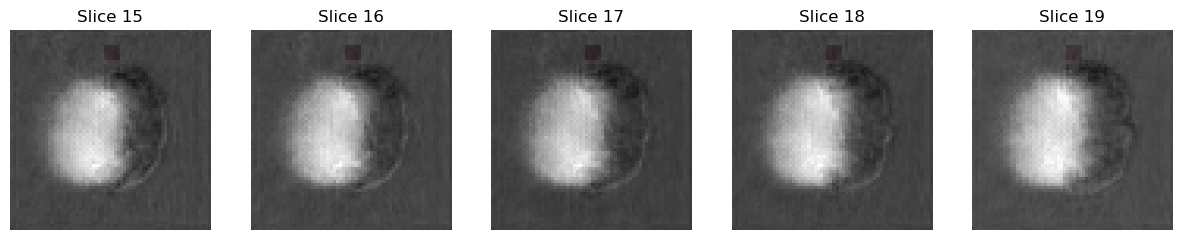

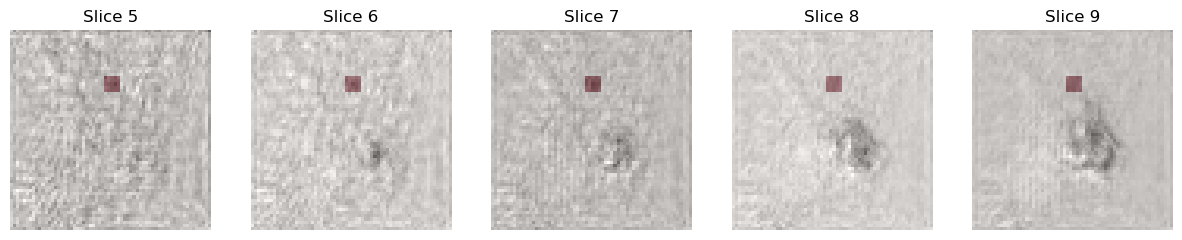

In [ ]:
mask_true_noise = np.zeros((64,64,64), dtype=bool)
mask_true_noise[5:10,15:20,30:35] = True


fig, ax = plt.subplots(1,5, figsize=(15,5))
slices_to_show = [i for i in range(30,35)]

for i, z in enumerate(slices_to_show):
    ax[i].imshow(preds0[12, :, :, z], cmap='gray')
    ax[i].imshow(mask_true_noise[:, :, z], cmap='Reds', alpha=0.4)
    ax[i].set_title(f'Slice {z}')
    ax[i].axis('off')

plt.show()

fig, ax = plt.subplots(1,5, figsize=(15,5))
slices_to_show = [i for i in range(15,20)]

for i, z in enumerate(slices_to_show):
    ax[i].imshow(preds0[12, :, z, :], cmap='gray')
    ax[i].imshow(mask_true_noise[:, z, :], cmap='Reds', alpha=0.1)
    ax[i].set_title(f'Slice {z}')
    ax[i].axis('off')

plt.show()

fig, ax = plt.subplots(1,5, figsize=(15,5))
slices_to_show = [i for i in range(5,10)]

for i, z in enumerate(slices_to_show):
    ax[i].imshow(preds0[27, z, :, :], cmap='gray')
    ax[i].imshow(mask_true_noise[z, :, :], cmap='Reds', alpha=0.4)
    ax[i].set_title(f'Slice {z}')
    ax[i].axis('off')

plt.show()

### tSNR of predictions

In [147]:
calc_SNR(image=preds0, image_type='Recon')

tensor(0.3864) tensor(0.0086)


tensor(45.1855)

### ROI position on original LS

In order of comparison, the tSNR was also calculated for the original LS volume, using the same participant as was used as test data. 

In [ ]:
orig_LS_path = 'Insert path'

orig_LS_img = nib.load(orig_LS_path).get_fdata()

In [7]:
orig_LS_img = orig_LS_img[:,:,:,120:172] # Extracting the same temporal slices as used for the other calculations
orig_LS_img = torch.tensor(orig_LS_img, dtype=torch.float32)
orig_LS_img = orig_LS_img.permute(3,0,1,2)

In [8]:
orig_LS_img.shape

torch.Size([52, 64, 64, 64])

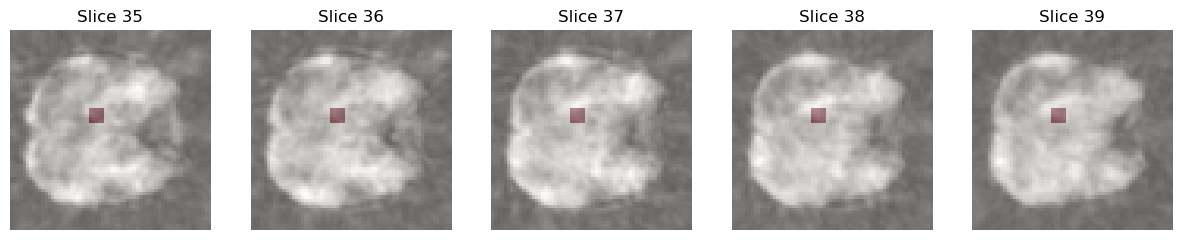

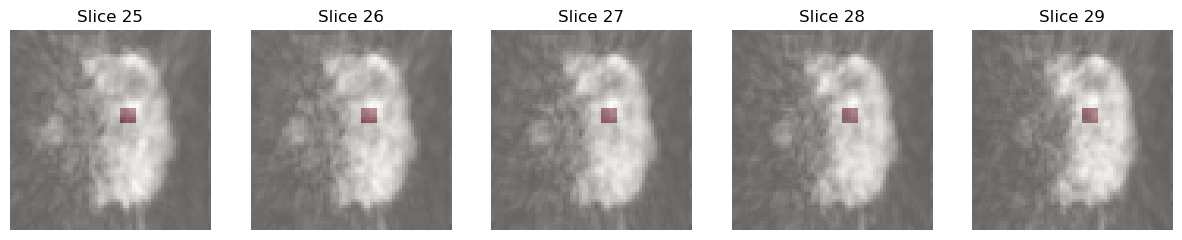

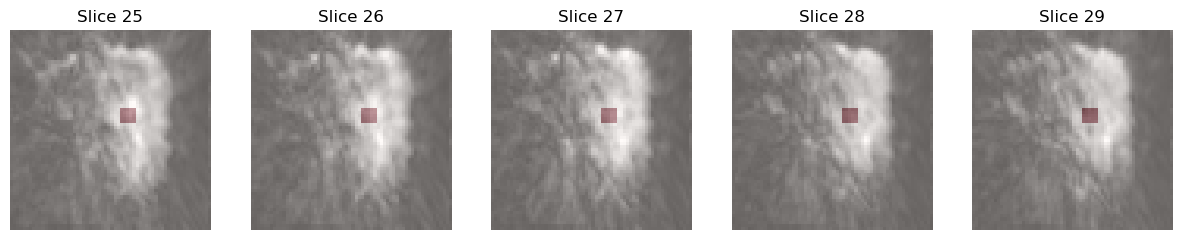

In [126]:
mask_LS = np.zeros((64,64,64), dtype=bool)
mask_LS[25:30,25:30,35:40] = True

fig, ax = plt.subplots(1,5, figsize=(15,5))
slices_to_show = [i for i in range(35,40)]

for i, z in enumerate(slices_to_show):
    ax[i].imshow(orig_LS_img[12, :, :, z], cmap='gray')
    ax[i].imshow(mask_LS[:, :, z], cmap='Reds', alpha=0.4)
    ax[i].set_title(f'Slice {z}')
    ax[i].axis('off')

plt.show()

fig, ax = plt.subplots(1,5, figsize=(15,5))
slices_to_show =  [i for i in range(25,30)]

for i, z in enumerate(slices_to_show):
    ax[i].imshow(orig_LS_img[12, :, z, :], cmap='gray')
    ax[i].imshow(mask_LS[:, z, :], cmap='Reds', alpha=0.4)
    ax[i].set_title(f'Slice {z}')
    ax[i].axis('off')

plt.show()

fig, ax = plt.subplots(1,5, figsize=(15,5))
slices_to_show = [i for i in range(25,30)]

for i, z in enumerate(slices_to_show):
    ax[i].imshow(orig_LS_img[12, z, :, :], cmap='gray')
    ax[i].imshow(mask_LS[z, :, :], cmap='Reds', alpha=0.4)
    ax[i].set_title(f'Slice {z}')
    ax[i].axis('off')

plt.show()

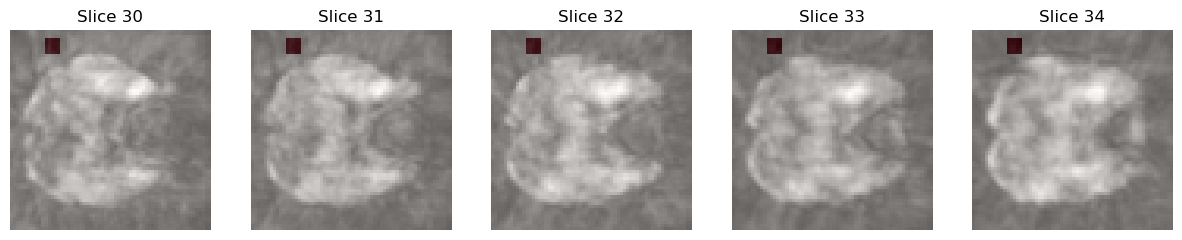

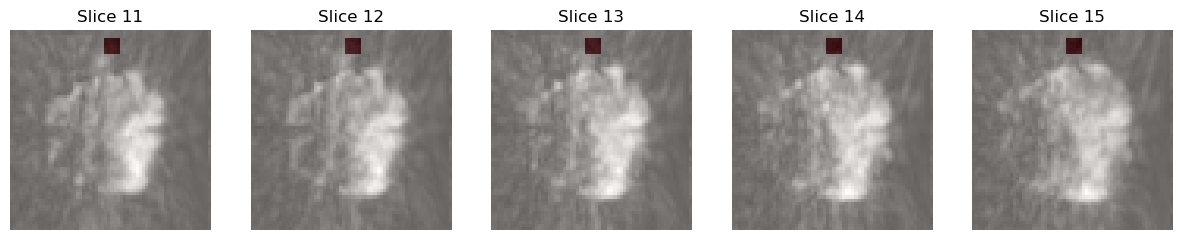

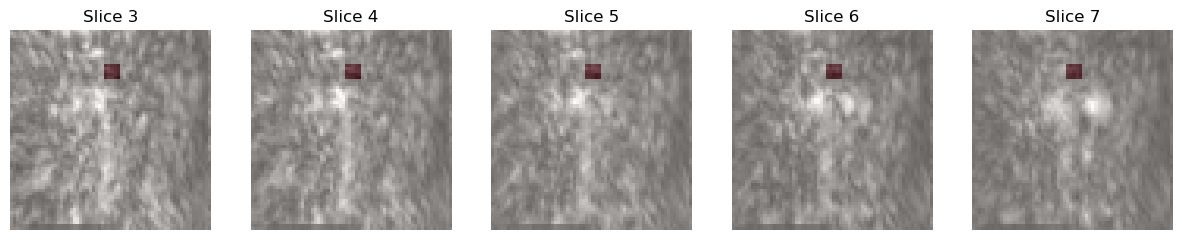

In [ ]:
mask_LS_noise = np.zeros((64,64,64), dtype=bool)
mask_LS_noise[3:8,11:16,30:35] = True


fig, ax = plt.subplots(1,5, figsize=(15,5))
slices_to_show = [i for i in range(30,35)]
for i, z in enumerate(slices_to_show):
    ax[i].imshow(orig_LS_img[12, :, :, z], cmap='gray')
    ax[i].imshow(mask_LS_noise[:, :, z], cmap='Reds', alpha=0.4)
    ax[i].set_title(f'Slice {z}')
    ax[i].axis('off')

plt.show()

fig, ax = plt.subplots(1,5, figsize=(15,5))
slices_to_show = [i for i in range(11,16)]

for i, z in enumerate(slices_to_show):
    ax[i].imshow(orig_LS_img[12, :, z, :], cmap='gray')
    ax[i].imshow(mask_LS_noise[:, z, :], cmap='Reds', alpha=0.4)
    ax[i].set_title(f'Slice {z}')
    ax[i].axis('off')

plt.show()

fig, ax = plt.subplots(1,5, figsize=(15,5))
slices_to_show = [i for i in range(3,8)]

for i, z in enumerate(slices_to_show):
    ax[i].imshow(orig_LS_img[27, z, :, :], cmap='gray')
    ax[i].imshow(mask_LS_noise[z, :, :], cmap='Reds', alpha=0.4)
    ax[i].set_title(f'Slice {z}')
    ax[i].axis('off')

plt.show()

### tSNR of original LS

In [9]:
calc_SNR(image=orig_LS_img, image_type='LS')

tensor(5034.2314) tensor(275.6186)


tensor(18.2652)